In [3]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
#classical optimizer to update ansatz
from qiskit.aqua.components.optimizers import SLSQP
#initial ansatz to be optimized with VQE
from qiskit.chemistry.components.initial_states import HartreeFock
#vary HF to VQE ansatz
from qiskit.chemistry.components.variational_forms import UCCSD
#setup molecule
from qiskit.chemistry.drivers import PySCFDriver
#mapping
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [10]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
# curly bracelet: dimension we can vary
distances = np.arange(0.50,4.25,0.25)
vqe_energies = [] #GS energy from variational quantum eigensolver
hf_energies = [] #initial guess
exact_energies = [] #classical

In [13]:
for i,d in enumerate(distances):
    print('step',i)
    
    #set up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(qubit_mapping = QubitMappingType.PARITY, 
                           two_qubit_reduction=True, 
                           freeze_core=True, 
                           orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run(qmolecule)
    
    #exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators = aux_ops).compute_minimum_eigenvalue()
    exact_result = operator.process_algorithm_result(exact_result)
    
    #VQE
    optimizer = SLSQP(maxiter=1000) #try 1000 times before converging
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'], 
                                operator.molecule_info['num_particles'],
                               qubit_mapping=operator._qubit_mapping,
                               two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


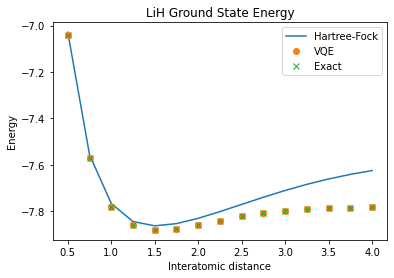

In [14]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')